# Simulating and Optimizing Trains, Passengers and Travelling Time by varying Signalling Blocks and Weather conditions using Possion  Distribution

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset-Creation" data-toc-modified-id="Dataset-Creation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset Creation</a></span></li><li><span><a href="#Data-for-Simulation" data-toc-modified-id="Data-for-Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data for Simulation</a></span></li><li><span><a href="#Pictorial-Representation-of-HS2-Line" data-toc-modified-id="Pictorial-Representation-of-HS2-Line-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pictorial Representation of HS2 Line</a></span></li><li><span><a href="#Define-Process" data-toc-modified-id="Define-Process-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define Process</a></span></li><li><span><a href="#Line-Function" data-toc-modified-id="Line-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Line Function</a></span></li><li><span><a href="#Final-Simulation-Result" data-toc-modified-id="Final-Simulation-Result-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final Simulation Result</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Introduction


<font size="3">The main objective of this research work is to simulate a maximum number of trains in an hour by varying the number of blocks from 1 to 14 between station __'London Old Oak Common' and 'Birmingham Interchange'__ of high-speed train planned __HS2 line__ from London to Birmingham. As part of optimization two major objectives are considered. Firstly, minimizing the average travelling time includes driving time, dwell time and weather conditions. The second one is to maximize the number of passengers in an hour. Almost all aspects of the project descriptions like acceleration, deceleration, max velocity, time to reach max speed, time to decelerate back to 0 from max speed, weather conditions, max passengers per train and the maximum average waiting time are considered.</font>

In [5]:
#Import Neccessary Packages

import pandas as pd 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import time
import random
from numpy import random
import simpy
import simpy.events as evt
pd.options.mode.chained_assignment = None

## Dataset Creation

In [31]:
# Dataset Creation

class dataset:
   # Dataset with number of blocks needs to be passed as Input 
    def __init__(self, total_block):
        self.total_block = total_block

    # Block b1 and b3 are stationary and b2 is created dynamical
    def blocks(self):
        total_block = self.total_block
        b1 = 1
        b3 = 2
        b2 = (total_block - b1 - b3)
        return b1, b2, b3    

    # Split blocks according to stations
    def split_block(self):
        blocks = self.blocks
        b1, b2, b3 = blocks()
        y = b1 + b2 + b3 + 3
        return y
    
    # DataFrame creation and assigning initial value to the stations
    def create_dataframe(self):
        # Dummy DataFrame creation    
        data = pd.DataFrame()
        split_block = self.split_block
        for i in range(split_block()):
            data.at[i, 'block_number'] = i+1
            data.at[i, 'from_location'] = 'S' + str(i+1)
            data.at[i, 'to_location'] = 'S' + str(i+2)
        return data
    
    # Allocating Actual Station name to the blocks
    def station_name(self, data):
        blocks = self.blocks
        a, b, c = blocks()
        data = self.create_dataframe()
        
        x = 0
        data['from_location'][x] = 'London Euston' 

        x += 1
        data['to_location'][x] = 'London Old Oak Common'
        data['from_location'][x+1] = 'London Old Oak Common'

        x = x + b + 1
        data['to_location'][x] = 'Birmingham Interchange'
        data['from_location'][x+1] = 'Birmingham Interchange'

        x = x + c + 1
        data['to_location'][x] = 'Birmingham Curzon Street'
        return data
    
    # disTo function to calculate distance based on time
    def disTo(self,T,maxV=83.3, A=0.72,D=0.36):
        """
        A       constant acceleration, m/s²
        D       constant deceleration, m/s²
        maxV    maximumum velocity, m/s
        d       distance, km
        return  time in seconds required to travel
        """
        
        tA = maxV/A         # time to accelerate to maxV
        tD = maxV/D         # time to decelerate to 0 from maxV
        t = tD + tA         # total acc + dec
        #print(t)
        
        dA = (A*tA*tA+D*tD*tD)/2   # distance traveled during acceleration from 0 to maxV and back to 0
        if (T < t):                # train never reaches full speed?
            return np.sqrt(4.0*d/(A*D)) # time needed to accelerate to half-way point then decelerate to destination
        else:
            return dA + (T-t)*maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination
    
    # Distance allocation to each blocks equally based on number of blocks
    def final_dataset(self, data):
        blocks = self.blocks
        a, b, c = blocks()
        k = (self.split_block() - 3)
        data = self.station_name(data)        
        
        distance_1 = self.disTo(300)        
        distance_1_split = distance_1 / (a+1)
        distance_2 = 145000
        distance_2_split = distance_2 / (b+1)
        distance_3 = self.disTo(540)
        distance_3_split = distance_3 / (c+1)
        
        data['distance'] =''
        data['running_time'] =''
        
        # Splitting distance equally between the stations
        for x in range(a+1):    
            data['distance'][x] = distance_1_split
            data['running_time'][x] = 300/(a+1)
        
        for y in range(a+1, k):
            data['distance'][y] = distance_2_split
            data['running_time'][y] = 1860/(b+1)
        
        for z in range(k, k+3):
            data['distance'][z] = distance_3_split
            data['running_time'][z] = 540/(c+1)
        
        return data

In [32]:
# Tune the number of block split from 4 to 17
a = dataset(4)

<font size="3">This Split block will be constant from London Euston to London Old Oak Common and Birmingham Interchange to Birmingham Curzon Street stations. The number of blocks between London Old Oak Common to Birmingham Interchange vary from 1 to 14.</font>

In [33]:
# Split Block Object stored in a variable.
y = a.split_block()
y

7

In [34]:
# Dataset from Class is called and stored in a variable
data = a.final_dataset(a.station_name(a.create_dataframe()))

<font size="3">View Data from the class dataset</font>

In [6]:
data

,block_number,from_location,to_location,distance,running_time
0,1.0,London Euston,S2,5400,150
1,2.0,S2,London Old Oak Common,5400,150
2,3.0,London Old Oak Common,S4,72500,930
3,4.0,S4,Birmingham Interchange,72500,930
4,5.0,Birmingham Interchange,S6,10175.3,180
5,6.0,S6,S7,10175.3,180
6,7.0,S7,Birmingham Curzon Street,10175.3,180


 <font size="3">Time to travel a given distance based on acceleration, deceleration, time to accelerate, time to decelerate and max velocity.</font>

In [7]:
def timeTo(A,D, maxV, d):
    """
    A       constant acceleration, m/s² - 0.72m/s²
    D       constant deceleration, m/s² - 0.36m/s²
    maxV    maximumum velocity, m/s - 83.3 m/s
    d       distance, km
    return  time in seconds required to travel
    """
    tA = 115.7          # time to accelerate to maxV
    tD = 231.4          # time to decelerate from maxV to 0
    #A = 0.72            
    #D = 0.36            
    dA = 14460                # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < dA):                # train never reaches full speed?
        return np.sqrt(4.0*(d/(A*D))) # time needed to accelerate to 1/3rd-way point then decelerate to destination
    else:
        return tD+tA + (d-dA)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

<font size="3">Unique Block number is taken from a dataset and stored in another dataframe</font>

In [8]:
block=data['block_number'].unique()
dl=pd.DataFrame(block, columns=['block_number'])
dl=dl.set_index('block_number')
dl

""
block_number
1.0
2.0
3.0
4.0
5.0
6.0
7.0


<font size="3">Running time from the dataset is taken and assigned to a new column 't'</font>

In [9]:
for i in range(len(data)):
    t1=data.at[i,'running_time']
    data.at[i, 't']=t1

<font size="3">a, d and v values are constant and added to the data</font>

In [10]:
data['d']=0.36
data['a']=0.72
data['v']=83.3

<font size="3">max value of a, d and v</font>

In [11]:
for b in block:
    dl.at[b, 'max a']=data[data['block_number']==b]['a'].max()
    dl.at[b, 'max d']=data[data['block_number']==b]['d'].max()
    dl.at[b, 'max v']=data[data['block_number']==b]['v'].max()
dl

,max a,max d,max v
block_number,,,
1.0,0.72,0.36,83.3
2.0,0.72,0.36,83.3
3.0,0.72,0.36,83.3
4.0,0.72,0.36,83.3
5.0,0.72,0.36,83.3
6.0,0.72,0.36,83.3
7.0,0.72,0.36,83.3


In [12]:
data

,block_number,from_location,to_location,distance,running_time,t,d,a,v
0,1.0,London Euston,S2,5400,150,150.0,0.36,0.72,83.3
1,2.0,S2,London Old Oak Common,5400,150,150.0,0.36,0.72,83.3
2,3.0,London Old Oak Common,S4,72500,930,930.0,0.36,0.72,83.3
3,4.0,S4,Birmingham Interchange,72500,930,930.0,0.36,0.72,83.3
4,5.0,Birmingham Interchange,S6,10175.3,180,180.0,0.36,0.72,83.3
5,6.0,S6,S7,10175.3,180,180.0,0.36,0.72,83.3
6,7.0,S7,Birmingham Curzon Street,10175.3,180,180.0,0.36,0.72,83.3


<font size="3">Values of a, v, d and distance is passed to timeTo function</font>

In [13]:
import numpy as np
for i in range(len(data)):
    b=data.iat[i, 0]
    a=dl.at[b, 'max a']
    v=dl.at[b, 'max v']
    d=dl.at[b, 'max d']
    data.at[i,'Drive_Time']=int(timeTo(a, d, v, data.at[i,'distance']))

In [14]:
# Remove unneccessary columns
data = data.drop(columns=['t', 'a', 'v', 'd', 'running_time'])

In [15]:
data

,block_number,from_location,to_location,distance,Drive_Time
0,1.0,London Euston,S2,5400,288.0
1,2.0,S2,London Old Oak Common,5400,288.0
2,3.0,London Old Oak Common,S4,72500,1043.0
3,4.0,S4,Birmingham Interchange,72500,1043.0
4,5.0,Birmingham Interchange,S6,10175.3,396.0
5,6.0,S6,S7,10175.3,396.0
6,7.0,S7,Birmingham Curzon Street,10175.3,396.0


In [16]:
# Dwell time of 30 seconds is added at the stations
data['dwell_time'] = ''

for i in range(y):
    if data['from_location'][i] in 'London Old Oak Common':
        data['dwell_time'][i] = 30
    elif data['from_location'][i] in 'Birmingham Interchange' :
        data['dwell_time'][i] = 30
    else:
        data['dwell_time'][i] = 0

## Data for Simulation
<font size="3">The dataset is comprised of from location, to location, distance, actual drive time and dwell time.</font>

In [17]:
data

,block_number,from_location,to_location,distance,Drive_Time,dwell_time
0,1.0,London Euston,S2,5400,288.0,0
1,2.0,S2,London Old Oak Common,5400,288.0,0
2,3.0,London Old Oak Common,S4,72500,1043.0,30
3,4.0,S4,Birmingham Interchange,72500,1043.0,0
4,5.0,Birmingham Interchange,S6,10175.3,396.0,30
5,6.0,S6,S7,10175.3,396.0,0
6,7.0,S7,Birmingham Curzon Street,10175.3,396.0,0


## Pictorial Representation of HS2 Line

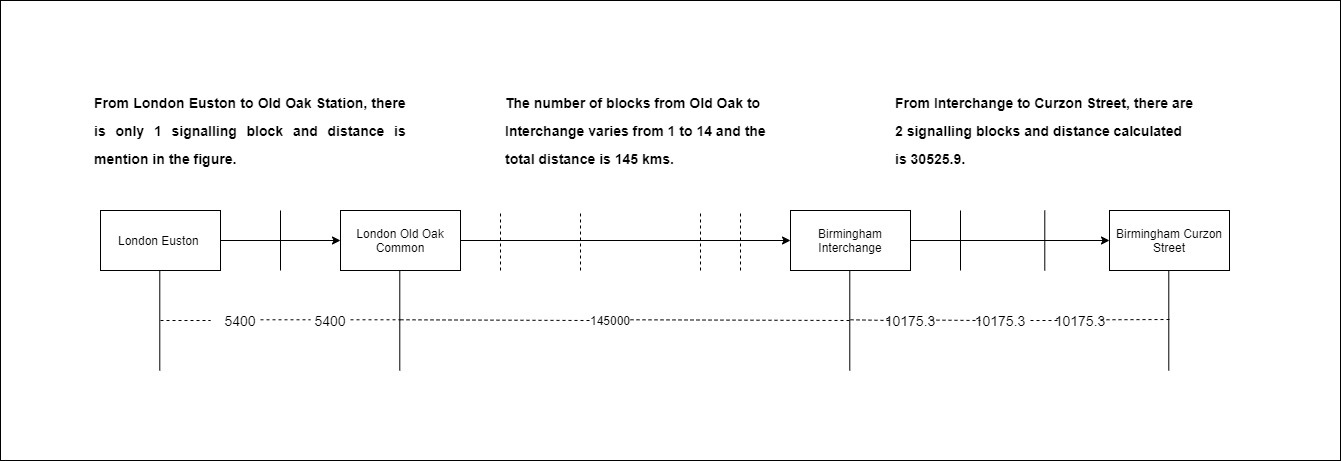

In [4]:
from IPython.display import Image
Image(filename='MSO_Assumption.png') 

## Define Process

<font size="3"> Class Train has 3 functions. 

1) Function process which explains the varying passengers' count that uses Poisson distribution. It also simulates the number of trains per hour based on the number of blocks from input and resource allocated.

2) The maximum number of passenger a Long train can hold is 70% of 630, which is 441.

3) In getOff function number of passengers, got off in each station is stored and based on this getOn function can allow remaining passengers to board the train.

Simpy resource [1] and poisson distribution for allocating number of passengers [2] are implemented as part of train function. </font>

In [18]:
class Train(object):  
    def __init__(self, env, i, counter_list, data, pass_list, maxP = 441): #70% of 630
        self.name = ' [Train '+f"{i:2d}"+']'
        self.data = data
        block = data['block_number']
        self.maxP = maxP
        self.p = 0
        self.pass_list = pass_list

    def process(self): 
        tp = 0
        for u in range(len(data['block_number'])): 
            u = random.choice(random.poisson(lam=441, size=len(data['block_number']))) #Passengers get On from LondonEuston
        for o in range(len(data['block_number'])):
            o = random.choice(random.poisson(lam=400, size=len(data['block_number']))) #Passengers get off- 0 first station
        if data['from_location'][0] == 'London Euston':                
            env.process(self.getOn(num=u, get_on_location='London Euston', get_off_location='London Old Oak Common'))           
            tp1 = u    
       
        for block in data['block_number']: # number of trains per block
            data1 = self.data[self.data['block_number'] == block]
            stations =   data1['from_location'].to_list() 
            stations +=  [data1['to_location'].to_list()[-1]]            
            from_location = stations[0] 
            to_location = stations[1]
            for Location in stations[:1]:
                data2 = self.data[self.data['from_location'] == Location]
                ind = data2.index.tolist()
                ind = ind[0]
                drivetime = data2.iloc[0].at['Drive_Time'] # drive time from dataset
                dwelltime = data2.iloc[0].at['dwell_time'] # 30 seconds waiting time in each stations
                
                # considering weather conditions delay from 10 to 100 seconds
                weather_conditions = random.choice(random.poisson(lam=(10,100), size= 1)) 
                yield env.timeout(dwelltime) # dwell time at each station of 30 seconds
                print(f"{now():s} {self.name:s} departed from {from_location:s} for {to_location:s}")
                yield env.timeout(drivetime)
                print(f"{now():s} {self.name:s} arrived {to_location:s}") 
                yield env.timeout(weather_conditions)
                
                # requesting resource for next train to stop till the block is empty
                req = counter_list[int(block - 1)].request()
                yield req
                
                # In each station number of passengers getOn and getOff are stored in tp1, tp2, tp3, tp4 and tp5 variables.
                if (data2['to_location'][ind] == 'London Old Oak Common'):
                    tp2 = u
                    tp3 = o
                    env.process(self.getOff(num=o, get_off_location=to_location))
                    env.process(self.getOn(num=u, get_on_location=from_location,get_off_location=to_location)) 
           
                if (data2['to_location'][ind] == 'Birmingham Interchange'):
                    tp4 = u
                    tp5 = o
                    env.process(self.getOff(num=o, get_off_location=to_location))
                    env.process(self.getOn(num=u, get_on_location=from_location,get_off_location=to_location))
                   
                   
                if (data2['to_location'][ind] == 'Birmingham Curzon Street'):
                    tp = tp1 + tp2 -tp3 +tp4 - tp5
                    env.process(self.getOff(num= tp, get_off_location=to_location))
                    total = tp1 + tp2 + tp4 # summation of people who getOn in each station
                    self.pass_list.append(total)     
            # release the resource once the train left the block
            counter_list[int(block - 1)].release(req)
            
# Function calculates number of passengers got off from each stations
    def getOff(self, num, get_off_location): 
        if self.p >= num:
            print("*********************************************************************************")
            print(f"{num:d} passengers got off from {self.name:s} in {get_off_location:s}")
            #print("*********************************************************************************")
            self.p -= num
        else:
            num = self.p
            print("*********************************************************************************")
            print(f" {self.name:s} is empty - only {num:d} passengers got off in {get_off_location:s}")
            #print("*********************************************************************************")
            self.p = 0
            yield env.timeout(0)

 # Function calculates number of passengers boarded from each stations
    def getOn(self, num, get_on_location, get_off_location):
        if (self.maxP is None) or (self.p + num <= self.maxP):
            print("*********************************************************************************")
            print(f"{num:d} passengers got on into {self.name:s} from {get_on_location:s} ")
            #print("*********************************************************************************")
            self.p += num
        else:
            num = self.maxP - self.p
            print("*********************************************************************************")
            print(f"{self.name:s} is full - only {num:d} passengers got on from {get_off_location:s}")
            #print("*********************************************************************************")
            self.p = self.maxP
            yield env.timeout(0)

##  Line Function 

<font size="3"> The below function is the main function and calls Class Train and initiate the whole simulation. It also counts how many trains are passed for an hour from 6:00:00 am to 7:00:00 am.

Resources are initiated to Train Class from line function.</font>

In [19]:
def line(env, y, start=6*3600, stop=7*3600):
    yield env.timeout(start-env.now) # line starts operating at 6am
    global total
    global pass_list
    global count
    global counter_list
    counter_list = []
    pass_list = []
    count = 1    # count number of trains per hour
    for z in range(0, y): # initiate resource based on total number of blocks
        counter = simpy.Resource(env, capacity=1)
        counter_list.append(counter)
    for i in range(len(data['block_number'])): # controls trains on each block
        t = Train(env,i, counter_list, data, pass_list)
        env.process(t.process())        
        #yield env.timeout(60)
        yield env.timeout(int(data['Drive_Time'][i] + data['dwell_time'][i]) + 5)
        if (env.now >= 21600 and env.now <= 25200): # train count from morning 6 am to 7 am
            count += 1

In [20]:
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"

def now():
    return daytime(env.now)

In [21]:
env = simpy.Environment()

In [22]:
env.process(line(env,y))

<Process(line) object at 0x132ebebcfc8>

<font size="3">Simulation output with number of passengers getOff, getOn in each station and train arrival and departure stations are also printed.</font>

In [23]:
env.run()

*********************************************************************************
411 passengers got on into  [Train  0] from London Euston 
06:00:00  [Train  0] departed from London Euston for S2
06:04:48  [Train  0] arrived S2
*********************************************************************************
428 passengers got on into  [Train  1] from London Euston 
06:04:53  [Train  1] departed from London Euston for S2
06:04:55  [Train  0] departed from S2 for London Old Oak Common
06:09:41  [Train  1] arrived S2
06:09:43  [Train  0] arrived London Old Oak Common
*********************************************************************************
 [Train  2] is full - only 441 passengers got on from London Old Oak Common
06:09:46  [Train  2] departed from London Euston for S2
*********************************************************************************
399 passengers got off from  [Train  0] in London Old Oak Common
******************************************************************

<font size="3">Train count from previous fucntion is stored in the variable trains.</font>

In [24]:
trains = count
trains

7

<font size="3">Average driving time for number of trains per hour is aggregated and stored in total_driving_time</font>

In [25]:
# Total drive time is aggregated
total_driving_time = sum(data['Drive_Time'])
total_driving_time

3850.0

<font size="3">Number of blocks by varying the inputs</font>

In [26]:
train_blocks = len(data['block_number'])
train_blocks

7

<font size="3">The below for loop gives the total number of passengers of all trains that travelled in an hour.</font>

In [27]:
tot = 0
for index, element in enumerate(pass_list):
    if index <= trains:
        tot += element
print(tot)

9090


In [28]:
# Final Simulation result sample
print(trains)
print(total_driving_time)
print(train_blocks)
print(tot)

7
3850.0
7
9090


In [29]:
#simulation_data = pd.DataFrame()

<font size="3">The final output from simulation stored in a CSV file for applying various optimization technique for Minimizing average travelling and maximizing the number of passengers.</font>

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
simulation_data.at[i, 'total_blocks'] = train_blocks
simulation_data.at[i, 'total_trains_per_hour'] = trains
simulation_data.at[i, 'total_driving_time'] = total_driving_time
simulation_data.at[i, 'total_passengers_per_hour'] = tot

In [35]:
simulation_data = simulation_data.reset_index(drop=True)

## Final Simulation Result

In [84]:
simulation_data

,total_blocks,total_trains_per_hour,total_driving_time,total_passengers_per_hour
0,4,7,"3,850","9,339"
1,5,7,"4,023","10,299"
2,6,8,"4,196","12,027"
3,7,8,"4,369","11,979"
4,8,9,"4,542","13,122"
5,9,9,"4,718","13,146"
6,10,10,"4,892","15,030"
7,11,11,"5,058","15,531"
8,12,11,"5,234","16,278"
9,13,9,"6,725","12,999"


In [34]:
#simulation_data.to_csv('D:/MSC_DA_SEM_2/MSO/simulation_result.csv', index=False)

## Conclusion

<font size="3">From this simulation results, by varying the values of the number of blocks (k) between __London Old Oak Common and Birmingham Interchange__ the number of trains per hour varied from 7 to 11 per hour. The major challenge of this simulation is to attain a maximum number of passengers travelled in an hour and an average travelling time of the trains per hour is implemented successfully. The final result from the simulation is tabulated and took forward for optimization.</font>